In [504]:
import pandas as pd
import os
import numpy as np
import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt


# import tensorflow as tf
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam

In [2]:
medium_data = pd.read_csv('data/medium_data.csv')
medium_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [3]:
medium_data.title

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

In [4]:
medium_data.shape

(6508, 10)

In [6]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

In [7]:
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

In [26]:
tokens = tokenizer("I, love English")

In [27]:
tokens

['i', ',', 'love', 'english']

In [93]:
class Vocabulary:
    def __init__(self, tokenizer, max_len):
        self.index_to_token = {0: "<unk>",
                               1: "<pad>"}
        
        self.token_to_index = {"<unk>": 0,
                               "<pad>": 1}
        
        self.max_len = max_len
        self.tokenizer = tokenizer
        
    def add_token(self, token):
        n = len(self.index_to_token)
        if self.token_to_index.get(token) is None:
            self.token_to_index[token] = n
            self.index_to_token[n] = token
            
    def get_token(self, index):
        return self.index_to_token[index]
    
    def get_index(self, token):
        if token not in self.token_to_index.keys():
            return self.token_to_index["<unk>"]
        else:
            return self.token_to_index[token]
    
    def get_sequence(self, sequence):
        tokens = tokenizer(sequence)
        # print(tokens)
        # n = len(tokens)
        # tokenized_sequence = np.ones(self.max_len)
        tokenized_sequence= [self.get_index(token) for token in tokens]
        return tokenized_sequence
                    

In [32]:
medium_data['tokens'] = medium_data.title.apply(lambda x: tokenizer(x))

In [36]:
medium_data['tokens'].apply(lambda x: len(x)).max()

27

In [404]:
vocabulary = Vocabulary(max_len=50, tokenizer=tokenizer)

In [405]:
def create_vocab(df):
    for i, row in df.iterrows():
        tokens = tokenizer(row.title)
        for token in tokens:
            vocabulary.add_token(token)

In [406]:
create_vocab(medium_data)

In [407]:
vocabulary.index_to_token

{0: '<unk>',
 1: '<pad>',
 2: 'a',
 3: 'beginner’s',
 4: 'guide',
 5: 'to',
 6: 'word',
 7: 'embedding',
 8: 'with',
 9: 'gensim',
 10: 'word2vec',
 11: 'model',
 12: 'hands-on',
 13: 'graph',
 14: 'neural',
 15: 'networks',
 16: 'pytorch',
 17: '&',
 18: 'geometric',
 19: 'how',
 20: 'use',
 21: 'ggplot2',
 22: 'in',
 23: 'python',
 24: 'databricks',
 25: 'save',
 26: 'files',
 27: 'csv',
 28: 'on',
 29: 'your',
 30: 'local',
 31: 'computer',
 32: 'step-by-step',
 33: 'implementation',
 34: 'of',
 35: 'gradient',
 36: 'descent',
 37: 'and',
 38: 'backpropagation',
 39: 'an',
 40: 'easy',
 41: 'introduction',
 42: 'sql',
 43: 'for',
 44: 'data',
 45: 'scientists',
 46: 'hypothesis',
 47: 'testing',
 48: 'visualized',
 49: 'latent',
 50: 'matrix',
 51: 'factorization',
 52: 'recommender',
 53: 'systems',
 54: 'which',
 55: '2020',
 56: 'candidate',
 57: 'is',
 58: 'the',
 59: 'best',
 60: 'at',
 61: 'twitter',
 62: '?',
 63: 'what',
 64: 'if',
 65: 'ai',
 66: 'understanding',
 67: 'were

In [408]:
vocabulary.get_index("sdjdjn")

0

In [44]:
len(vocabulary.index_to_token)

9002

In [104]:
tokenized_seq = vocabulary.get_sequence("I love python and machine learning!")

In [105]:
tokenized_seq

[71, 1791, 23, 37, 125, 126, 470]

In [103]:
def padd_sequence(sequence, max_len):
    n = len(sequence)
    padded_sequence = np.ones(max_len)
    padded_sequence[-n:] = sequence
    return padded_sequence

In [409]:
MAX_LENGTH = 50
NUM_WORDS = len(vocabulary.index_to_token)

In [410]:
padded_sequence = padd_sequence(tokenized_seq, MAX_LENGTH)

In [411]:
padded_sequence

array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 7.100e+01, 1.791e+03, 2.300e+01, 3.700e+01, 1.250e+02,
       1.260e+02, 4.700e+02])

### Create n-grams of sequences

In [412]:
input_sequences = []


for line in medium_data.title:
    tokenized_sequence = vocabulary.get_sequence(line)
    
    print(tokenized_sequence)
    
    for i in range(1, len(tokenized_sequence)):
        n_gram_sequence = tokenized_sequence[:i+1]
        padded_n_gram_sequence = padd_sequence(n_gram_sequence, 50)
        input_sequences.append(padded_n_gram_sequence)
    

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[12, 13, 14, 15, 8, 16, 17, 16, 18]
[19, 5, 20, 21, 22, 23]
[24, 19, 5, 25, 26, 22, 27, 28, 29, 30, 31]
[2, 32, 33, 34, 35, 36, 37, 38]
[39, 40, 41, 5, 42, 43, 44, 45]
[46, 47, 48]
[41, 5, 49, 50, 51, 52, 53]
[54, 55, 56, 57, 58, 59, 60, 61, 62]
[63, 64, 65, 11, 66, 67, 40, 62]
[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[81, 2, 82, 83, 84, 85]
[86, 2, 87, 88, 89]
[19, 5, 90, 91]
[92, 93, 43, 94, 95]
[19, 5, 96, 97, 98]
[99, 100, 101, 43, 44, 102]
[103, 104, 105, 106, 107, 37, 2, 106, 52]
[44, 108, 109, 110]
[111, 112, 43, 113, 114]
[115, 116, 117, 118, 119, 120, 121, 122, 58, 123, 124, 19, 125, 126, 127, 128, 5, 129, 130, 124]
[131, 34, 132, 133, 134, 34, 135, 117, 136, 117, 37, 137]
[138, 139, 140, 44, 141, 142, 143, 2, 144, 33, 34, 145, 94, 146, 62, 147]
[138, 139, 148, 28, 149, 150, 149, 28, 151, 62, 58, 152, 37, 153, 34, 154, 155]
[156, 43, 157, 158, 2, 159, 160, 100, 161]
[162, 57, 39, 95, 117, 163, 2, 108, 124, 164, 165, 2, 156, 166, 167

In [413]:
input_sequences

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 3.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 3., 4.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 3., 4., 5.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 3., 4., 5., 6.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 

In [414]:
input_sequences[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 3.])

In [415]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels, num_words):
        self.sequences = sequences
        self.labels = labels
        self.num_words = num_words #length of vocabulary
        
    def __len__(self):
        return len(self.sequences)    
    
    def __getitem__(self, idx):
        
        sequence = self.sequences[idx].type(torch.long)
        # torch.unsqueeze(sequence, 0)
        # print(sequence.shape)
        #create one-hot-encoded vector from the label
        label = torch.zeros(self.num_words, dtype=torch.float)
        label[int(self.labels[idx])]=1
        #label = self.labels[idx]
        #torch.unsqueeze(label, 0)
        
        
        
        return sequence, label


In [416]:
input_sequences= torch.Tensor(input_sequences)

In [466]:
input_sequences.shape

torch.Size([48317, 50])

In [417]:
train_sequences, val_sequences = train_test_split(input_sequences, test_size=0.3, shuffle=True)

In [418]:
train_sequences.shape

torch.Size([33821, 50])

In [419]:
X_train, y_train = train_sequences[:,:-1], train_sequences[:,-1]
X_val, y_val = val_sequences[:,:-1], val_sequences[:,-1]

In [420]:
y_train

tensor([238., 686.,  15.,  ...,  31.,  34.,  22.])

In [421]:
train_sequence_dataset = SequenceDataset(X_train, y_train, NUM_WORDS)
val_sequence_dataset = SequenceDataset(X_val, y_val, NUM_WORDS)

In [422]:
train_sequence_dataloader = DataLoader(train_sequence_dataset, batch_size=32, shuffle=True)
val_sequence_dataloader = DataLoader(val_sequence_dataset, batch_size=32, shuffle=True)

In [423]:
sequences, labels = next(iter(train_sequence_dataloader))
print(sequences.shape)
print(labels.shape)

torch.Size([32, 49])
torch.Size([32, 9002])


### Weights for the classes

In [374]:
from collections import Counter

In [380]:
tokens_frequences = Counter()

In [382]:
for tokens in medium_data['tokens']:
    tokens_frequences.update(tokens)
    
tokens_frequences.update(["<unk>", "<pad>"])    

In [383]:
tokens_frequences

Counter({'a': 2662,
         'beginner’s': 20,
         'guide': 176,
         'to': 3674,
         'word': 30,
         'embedding': 8,
         'with': 1026,
         'gensim': 4,
         'word2vec': 2,
         'model': 124,
         'hands-on': 2,
         'graph': 18,
         'neural': 150,
         'networks': 122,
         'pytorch': 40,
         '&': 238,
         'geometric': 6,
         'how': 1790,
         'use': 182,
         'ggplot2': 2,
         'in': 1622,
         'python': 292,
         'databricks': 2,
         'save': 52,
         'files': 8,
         'csv': 4,
         'on': 586,
         'your': 1616,
         'local': 14,
         'computer': 50,
         'step-by-step': 14,
         'implementation': 28,
         'of': 1974,
         'gradient': 6,
         'descent': 10,
         'and': 1818,
         'backpropagation': 8,
         'an': 488,
         'easy': 68,
         'introduction': 104,
         'sql': 30,
         'for': 1404,
         'data': 768,
  

In [384]:
len(tokens_frequences)

9002

In [385]:
vocabulary.index_to_token

{0: '<unk>',
 1: '<pad>',
 2: 'a',
 3: 'beginner’s',
 4: 'guide',
 5: 'to',
 6: 'word',
 7: 'embedding',
 8: 'with',
 9: 'gensim',
 10: 'word2vec',
 11: 'model',
 12: 'hands-on',
 13: 'graph',
 14: 'neural',
 15: 'networks',
 16: 'pytorch',
 17: '&',
 18: 'geometric',
 19: 'how',
 20: 'use',
 21: 'ggplot2',
 22: 'in',
 23: 'python',
 24: 'databricks',
 25: 'save',
 26: 'files',
 27: 'csv',
 28: 'on',
 29: 'your',
 30: 'local',
 31: 'computer',
 32: 'step-by-step',
 33: 'implementation',
 34: 'of',
 35: 'gradient',
 36: 'descent',
 37: 'and',
 38: 'backpropagation',
 39: 'an',
 40: 'easy',
 41: 'introduction',
 42: 'sql',
 43: 'for',
 44: 'data',
 45: 'scientists',
 46: 'hypothesis',
 47: 'testing',
 48: 'visualized',
 49: 'latent',
 50: 'matrix',
 51: 'factorization',
 52: 'recommender',
 53: 'systems',
 54: 'which',
 55: '2020',
 56: 'candidate',
 57: 'is',
 58: 'the',
 59: 'best',
 60: 'at',
 61: 'twitter',
 62: '?',
 63: 'what',
 64: 'if',
 65: 'ai',
 66: 'understanding',
 67: 'were

In [386]:
vocabulary.token_to_index

{'<unk>': 0,
 '<pad>': 1,
 'a': 2,
 'beginner’s': 3,
 'guide': 4,
 'to': 5,
 'word': 6,
 'embedding': 7,
 'with': 8,
 'gensim': 9,
 'word2vec': 10,
 'model': 11,
 'hands-on': 12,
 'graph': 13,
 'neural': 14,
 'networks': 15,
 'pytorch': 16,
 '&': 17,
 'geometric': 18,
 'how': 19,
 'use': 20,
 'ggplot2': 21,
 'in': 22,
 'python': 23,
 'databricks': 24,
 'save': 25,
 'files': 26,
 'csv': 27,
 'on': 28,
 'your': 29,
 'local': 30,
 'computer': 31,
 'step-by-step': 32,
 'implementation': 33,
 'of': 34,
 'gradient': 35,
 'descent': 36,
 'and': 37,
 'backpropagation': 38,
 'an': 39,
 'easy': 40,
 'introduction': 41,
 'sql': 42,
 'for': 43,
 'data': 44,
 'scientists': 45,
 'hypothesis': 46,
 'testing': 47,
 'visualized': 48,
 'latent': 49,
 'matrix': 50,
 'factorization': 51,
 'recommender': 52,
 'systems': 53,
 'which': 54,
 '2020': 55,
 'candidate': 56,
 'is': 57,
 'the': 58,
 'best': 59,
 'at': 60,
 'twitter': 61,
 '?': 62,
 'what': 63,
 'if': 64,
 'ai': 65,
 'understanding': 66,
 'were': 6

In [387]:
def calculate_class_weights(tokens_frequences):
    total_samples = 0
    for token, count in tokens_frequences.items():
        total_samples+=count
    class_weights = vocabulary.token_to_index
    for token, count in tokens_frequences.items():
        class_weights[token] = total_samples/(NUM_WORDS*count)  
    
    return class_weights      

In [388]:
class_weights = calculate_class_weights(tokens_frequences)

In [389]:
class_weights

{'<unk>': 12.180848700288825,
 '<pad>': 12.180848700288825,
 'a': 0.0045758259580348706,
 'beginner’s': 0.6090424350144412,
 'guide': 0.0692093676152774,
 'to': 0.003315418807917481,
 'word': 0.4060282900096275,
 'embedding': 1.5226060875361032,
 'with': 0.011872172222503728,
 'gensim': 3.0452121750722063,
 'word2vec': 6.090424350144413,
 'model': 0.09823265080878084,
 'hands-on': 6.090424350144413,
 'graph': 0.6767138166827125,
 'neural': 0.0812056580019255,
 'networks': 0.09984302213351495,
 'pytorch': 0.3045212175072206,
 '&': 0.0511800365558354,
 'geometric': 2.0301414500481374,
 'how': 0.006804943407982583,
 'use': 0.06692774011147706,
 'ggplot2': 6.090424350144413,
 'in': 0.007509771085258215,
 'python': 0.04171523527496173,
 'databricks': 6.090424350144413,
 'save': 0.2342470903901697,
 'files': 1.5226060875361032,
 'csv': 3.0452121750722063,
 'on': 0.020786431229161816,
 'your': 0.00753765389869358,
 'local': 0.8700606214492017,
 'computer': 0.2436169740057765,
 'step-by-step':

In [397]:
weights = torch.Tensor([weight for _, weight in class_weights.items()])

In [398]:
weights

tensor([1.2181e+01, 1.2181e+01, 4.5758e-03,  ..., 6.0904e+00, 6.0904e+00,
        6.0904e+00])

In [495]:
class LSTM(nn.Module):
    """
    embedding_size - will be 100
    hidden_size - Can be chosen to dictate how much hidden "long term memory" the network will have
    output_size - This will be equal to the prediciton_periods input to get_x_y_pairs
    """
    def __init__(self, embedding_size, hidden_size, output_size, n_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(num_embeddings=NUM_WORDS, embedding_dim=embedding_size)
        
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True, num_layers=n_layers, bidirectional=True)
        
        self.linear = nn.Linear(2*hidden_size, output_size)
        
        self.dropout = nn.Dropout(p=0.5)
        
        
        
    def forward(self, x, hidden=None, carry=None):
        
        if hidden == None and carry ==None:
            hidden, carry = torch.randn(2*self.n_layers, len(x), self.hidden_size), torch.randn(2*self.n_layers, len(x), self.hidden_size)
        else:
            hidden = hidden
            carry = carry
            
        """        
        lstm_out - will contain the hidden states from all times in the sequence
        self.hidden - will contain the current hidden state and cell state
        """
        embeddings = self.embedding(x)
        
        output, (hidden, carry) = self.lstm(embeddings, (hidden, carry))
        
        output = self.dropout(output)
        
        predictions = self.linear(output[:,-1])
        
        
        
        return predictions
    

In [496]:
lstm_net = LSTM(embedding_size=50, hidden_size=64, output_size=NUM_WORDS, n_layers=1)

In [497]:
lstm_net

LSTM(
  (embedding): Embedding(9002, 50)
  (lstm): LSTM(50, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=9002, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [489]:
for layer in lstm_net.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(9002, 50)
Parameters : 
torch.Size([9002, 50])

Layer : LSTM(50, 64, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
Parameters : 
torch.Size([256, 50])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 50])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])

Layer : Linear(in_features=128, out_features=9002, bias=True)
Parameters : 
torch.Size([9002, 128])
torch.Size([9002])



In [498]:
EPOCHS = 50
learning_rate = 1e-3

#loss_fn = nn.CrossEntropyLoss(weight=weights)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_net.parameters(), lr=learning_rate)

In [499]:
def train(model, train_loader, val_loader, optimizer, loss_fn, EPOCHS):
    
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    
    for i in range(EPOCHS):
        accuracies = []
        losses=[]
        for sequences, labels in train_loader:
           outputs = model(sequences)
           
           loss = loss_fn(outputs, labels)
                     
           losses.append(loss.item())
                     
           optimizer.zero_grad() ## Clear previously calculated gradients
           loss.backward() ## Calculates Gradients
           optimizer.step() ## Update network weights.
           
           labels_pred = labels.argmax(dim=-1)
           outputs_pred = outputs.argmax(dim=-1)
           accuracy = accuracy_score(labels_pred, outputs_pred)
           accuracies.append(accuracy)
           
        print("Epoch {:d}: Train Loss : {:.3f}".format(i, torch.tensor(losses).mean()))
        print("Train Accuracy : {:.3f}".format(torch.tensor(accuracies).mean()))
        
        train_accuracy.append(torch.tensor(accuracies).mean())
        train_loss.append(torch.tensor(losses).mean())
       
       
        val_losses=[]
        val_accuracies = []
       
        with torch.no_grad():
            for sequences, labels in val_loader:
                outputs = model(sequences)
            
                loss = loss_fn(outputs, labels)
                        
                val_losses.append(loss.item())
                     
                      
                labels_pred = labels.argmax(dim=-1)
                outputs_pred = outputs.argmax(dim=-1)
                accuracy = accuracy_score(labels_pred, outputs_pred)
                val_accuracies.append(accuracy)
            
        print("Epoch {:d}: Val Loss : {:.3f}".format(i, torch.tensor(val_losses).mean()))
        print("Val Accuracy : {:.3f}".format(torch.tensor(val_accuracies).mean())) 
        
        val_loss.append(torch.tensor(val_losses).mean())
        val_accuracy.append(torch.tensor(val_accuracies).mean())
        
    
    return train_accuracy, val_accuracy, train_loss, val_loss    
           


In [500]:
train_accuracy, val_accuracy, train_loss, val_loss = train(lstm_net, 
                                                           train_sequence_dataloader, 
                                                           val_sequence_dataloader, 
                                                           optimizer, 
                                                           loss_fn, 
                                                           EPOCHS)

Epoch 0: Train Loss : 7.344
Train Accuracy : 0.047
Epoch 0: Val Loss : 7.180
Val Accuracy : 0.059
Epoch 1: Train Loss : 6.837
Train Accuracy : 0.073
Epoch 1: Val Loss : 7.096
Val Accuracy : 0.083
Epoch 2: Train Loss : 6.569
Train Accuracy : 0.095
Epoch 2: Val Loss : 7.074
Val Accuracy : 0.095
Epoch 3: Train Loss : 6.337
Train Accuracy : 0.105
Epoch 3: Val Loss : 7.104
Val Accuracy : 0.103
Epoch 4: Train Loss : 6.115
Train Accuracy : 0.116
Epoch 4: Val Loss : 7.143
Val Accuracy : 0.108
Epoch 5: Train Loss : 5.918
Train Accuracy : 0.125
Epoch 5: Val Loss : 7.227
Val Accuracy : 0.115
Epoch 6: Train Loss : 5.716
Train Accuracy : 0.134
Epoch 6: Val Loss : 7.316
Val Accuracy : 0.117
Epoch 7: Train Loss : 5.532
Train Accuracy : 0.142
Epoch 7: Val Loss : 7.419
Val Accuracy : 0.119
Epoch 8: Train Loss : 5.353
Train Accuracy : 0.150
Epoch 8: Val Loss : 7.500
Val Accuracy : 0.123
Epoch 9: Train Loss : 5.188
Train Accuracy : 0.156
Epoch 9: Val Loss : 7.661
Val Accuracy : 0.119
Epoch 10: Train Loss

In [501]:
torch.save(lstm_net.state_dict(), "models/lstm.pt")

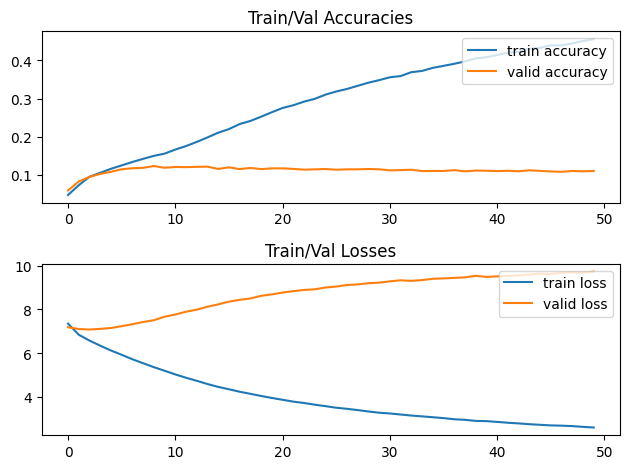

In [507]:
fig, axes = plt.subplots(ncols=1, nrows=2)

axes[0].plot(range(EPOCHS), train_accuracy, label="train accuracy")
axes[0].plot(range(EPOCHS), val_accuracy, label="valid accuracy")
axes[0].legend(loc = "upper right")
axes[0].set_title("Train/Val Accuracies")

axes[1].plot(range(EPOCHS), train_loss, label="train loss")
axes[1].plot(range(EPOCHS), val_loss, label="valid loss")
axes[1].legend(loc = "upper right")
axes[1].set_title("Train/Val Losses")

plt.tight_layout()
plt.show()


In [525]:
phrase = "I am going to "
next_word = "study"
while next_word != '.':
    phrase = phrase+" "+next_word
    print(phrase)
    sequence =  vocabulary.get_sequence(phrase)
    torch_sequence = torch.Tensor(sequence).type(torch.long)
    torch_sequence.unsqueeze_(dim=0)
    output = lstm_net(torch_sequence)
    softmax = nn.Softmax(dim=-1)
    probabilities = softmax(output)
    index = probabilities.argmax(dim=-1)
    next_word = vocabulary.get_token(index.item())
    print(next_word)

I am going to  study
the
I am going to  study the
right
I am going to  study the right
meaning
I am going to  study the right meaning
of
I am going to  study the right meaning of
your
I am going to  study the right meaning of your
ml
I am going to  study the right meaning of your ml
with
I am going to  study the right meaning of your ml with
e-signature🚀
I am going to  study the right meaning of your ml with e-signature🚀
tpu
I am going to  study the right meaning of your ml with e-signature🚀 tpu
in
I am going to  study the right meaning of your ml with e-signature🚀 tpu in
large
I am going to  study the right meaning of your ml with e-signature🚀 tpu in large
uninterrupted
I am going to  study the right meaning of your ml with e-signature🚀 tpu in large uninterrupted
what’s
I am going to  study the right meaning of your ml with e-signature🚀 tpu in large uninterrupted what’s
inside
I am going to  study the right meaning of your ml with e-signature🚀 tpu in large uninterrupted what’s inside
